#Load data

In [1]:
import sys
sys.path.insert(1, '/data1/tam/python_graph_utilities_v2/Codes/')
import torch
from dataset import OneDDatasetBuilder, OneDDatasetLoader
from plot import *
from preprocessing import dataset_split_to_loader
from networks_v1 import RecurrentFormulationNetwork

import torch_geometric
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
# %env CUDA_VISIBLE_DEVICE=2
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

In [2]:
# define argument
class objectview(object):
    def __init__(self, d) -> None:
        self.__dict__ = d
    def setattr(self, attr_name, attr_value):
        self.__dict__[attr_name] = attr_value

args = objectview(d={
    # data params
    'total_time': 4.8,
    'n_time': 201,
    'batch_size': 2000,
    'batch_n_time': 20,
    'batch_step': 1,
    'batch_recursive': True,
    # model params
    'n_field': 2,
    'n_meshfield': (11, 0),
    'n_boundaryfield': 1,
    'latent_size': 128,
    'n_latent': 10,
    'hidden_size': 128,
    'n_hidden': 4,
    'forward_sequence': False,
    # training params
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr': 2e-7,
    'weight_decay': 5e-4,
    'epoch': 100,
    'criterion': torch.nn.MSELoss(),
})

In [3]:
# # Build dataset
# dataset = OneDDatasetBuilder(
#     raw_dir='/data1/tam/datasets',
#     root_dir='/data1/tam/downloaded_datasets_new1',
#     data_names='all',
#     time_names=[str(i).zfill(3) for i in range(201)]
# )

# # Load dataset
# dataset = OneDDatasetLoader(
#     root_dir='/data1/tam/downloaded_datasets_WT',
#     sub_dir='processed',
#     data_names='all',
#     time_names=[str(i).zfill(3) for i in range(201)]
# )

# dataset = dataset.normalizing(
#     sub_dir='normalized',
#     scalers = {
#         'node_attr' : ['quantile_transformer', 0],
#         # 'edge_attr' : ['minmax_scaler', 0],
#         'pressure' : ['quantile_transformer', None],
#         'flowrate' : ['quantile_transformer', None]
#     }
# )

# dataset = dataset.batching(
#     batch_size = args.batch_size,
#     batch_n_times = args.batch_n_time, 
#     recursive = args.batch_recursive, 
#     sub_dir='/batched', 
#     step=args.batch_step
# )

In [4]:
# Load dataset
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_WT',
    sub_dir='batched',
    data_names='all',
    time_names=[str(i).zfill(3) for i in range(201)]
)

train_loader, test_loader = dataset_split_to_loader(
    dataset = dataset,
    subset_ids = {
        'train': list(range(0, 20)),
        'test': list(range(30, 35))
    },
    n_datas_per_batch = 2
)

In [5]:
# prepare model
model = RecurrentFormulationNetwork(
    n_field=args.n_field,
    n_meshfield=args.n_meshfield,
    n_boundaryfield=args.n_boundaryfield,
    n_hidden=args.n_hidden,
    hidden_size=args.hidden_size,
    n_latent=args.n_latent,
    latent_size=args.latent_size,
    integration=None
)
# model = torch_geometric.nn.DataParallel(model)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# args.setattr(attr_name='optimizer', attr_value=optimizer)

#Training

In [6]:
def train(model, data, args, forward_sequence=False):
    ## Field tensor: Tensor(n_node, n_time, n_field)
    F_true = torch.cat([
            data.pressure.unsqueeze(2),
            data.flowrate.unsqueeze(2)
        ], dim=2).float().to(args.device)
    if not forward_sequence:
        # forward only initial state
        F = F_true[:,0,:]
    else:
        # forward all timestep
        F = F_true
    F_true = F_true[:,1:,:]
    
    ## Connectivity/edge_index: Tensor(2, n_edge)
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
    )], dim=1).to(args.device)

    ## Mesh features: Tuple(Tensor(n_node, n_node_attr), Tensor(n_edge, n_edge_attr))
    node_attr = data.node_attr.float().to(args.device)
    # edge_attr = data.edge_attr.float().to(args.device)
    # edge_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0).float().to(args.device)
    edge_attr = None
    meshfield = (node_attr, edge_attr)

    ## Boundary field
    # boundaryfield = None
    boundaryfield = torch.cat([data.flowrate[0,:].unsqueeze(0)]*data.flowrate.size(0), dim=0)
    boundaryfield = boundaryfield.float().to(args.device)

    ## Time tensor
    # time = data.time.float().to(args.device)
    time = None

    ## Predict output sequence
    F_pred = model(
        F = F,
        edge_index=edge_index,
        meshfield=meshfield,
        boundaryfield=boundaryfield,
        time=time,
        forward_sequence=forward_sequence,
        n_time=data.flowrate.size(1)
    )
    
    ## loss calculation
    # print(F_true.size(), F_pred.size())
    loss = args.criterion(F_pred, F_true)
    loss.backward()
    optimizer.step()

    return loss.item()
# train(model, dataset[0], args, forward_sequence=True)

In [7]:
def eval(model, data, args, forward_sequence=False):
    ## Field tensor: Tensor(n_node, n_time, n_field)
    F_true = torch.cat([
            data.pressure.unsqueeze(2),
            data.flowrate.unsqueeze(2)
        ], dim=2).float().to(args.device)
    if not forward_sequence:
        # forward only initial state
        F = F_true[:,0,:]
    else:
        # forward all timestep
        F = F_true
    F_true = F_true[:,1:,:]
    
    ## Connectivity/edge_index: Tensor(2, n_edge)
    # edge_index = data.edge_index.to(args.device)
    edge_index = torch.cat([
        data.edge_index, torch.flip(data.edge_index, dims=[0]
    )], dim=1).to(args.device)

    ## Mesh features: Tuple(Tensor(n_node, n_node_attr), Tensor(n_edge, n_edge_attr))
    node_attr = data.node_attr.float().to(args.device)
    # edge_attr = data.edge_attr.float().to(args.device)
    # edge_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0).float().to(args.device)
    edge_attr = None
    meshfield = (node_attr, edge_attr)

    ## Boundary field
    # boundaryfield = None
    boundaryfield = torch.cat([data.flowrate[0,:].unsqueeze(0)]*data.flowrate.size(0), dim=0)
    boundaryfield = boundaryfield.float().to(args.device)

    ## Time tensor
    # time = data.time.float().to(args.device)
    time = None

    ## Predict output sequence
    with torch.no_grad():
        F_pred = model(
            F = F,
            edge_index=edge_index,
            meshfield=meshfield,
            boundaryfield=boundaryfield,
            time=time,
            forward_sequence=forward_sequence,
            n_time=data.flowrate.size(1)
        )
        
        ## loss calculation
        loss = args.criterion(F_pred, F_true)

    return loss.item()

In [8]:
# Training
total_train_loss = []
total_eval_loss = []
# batch = enumerate(list(range(0,10)))
for epoch in range(args.epoch):
    if epoch == 10:
        args.forward_sequence = False
    torch.cuda.empty_cache()
    train_loss = 0
    for i in range(train_loader.__len__()):
        data = next(iter(train_loader))
        # print(data)
        train_loss += train(model=model, data=data, args=args, forward_sequence=True)

    # train_loss /= train_loader.__len__() # len(train_dataset)
    total_train_loss.append(train_loss)

    eval_loss = 0
    for i in range(test_loader.__len__()):
        data = next(iter(test_loader))
        eval_loss += eval(model=model, data=data, args=args)
    # eval_loss /= test_loader.__len__() #len(eval_dataset)
    total_eval_loss.append(eval_loss)
    
    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')
    if (epoch+1) % 20 == 0:
        torch.save(model.state_dict(), f'models/parc_test_epoch{epoch+1}.pth')

Epoch 0: train loss = 0.0007383470256101532; eval loss = 0.008608319267295883
Epoch 1: train loss = 0.00014137942274938808; eval loss = 0.0006384928038301041
Epoch 2: train loss = 9.109048257815999e-05; eval loss = 0.008876232077454915
Epoch 3: train loss = 0.0003607565750627373; eval loss = 0.021577974257525057
Epoch 4: train loss = 0.00048504009056671293; eval loss = 0.014827130471530836
Epoch 5: train loss = 0.00015844432515699225; eval loss = 0.0018555353085503157
Epoch 6: train loss = 6.278420924221706e-05; eval loss = 0.0022635505247308174
Epoch 7: train loss = 0.00020398324852166638; eval loss = 0.006362127378451987
Epoch 8: train loss = 0.00022930067827786615; eval loss = 0.0027291561423226085
Epoch 9: train loss = 7.716482751884968e-05; eval loss = 0.0006974422262828739
Epoch 10: train loss = 5.7574133449200815e-05; eval loss = 0.00391846212096425
Epoch 11: train loss = 0.00011155997264111761; eval loss = 0.005485056094585161
Epoch 12: train loss = 9.145794263432094e-05; eval 

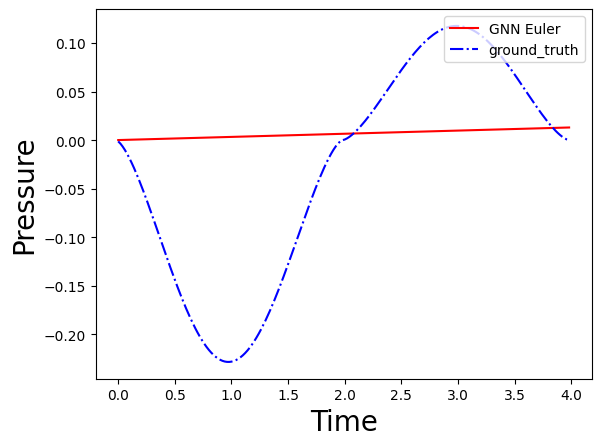

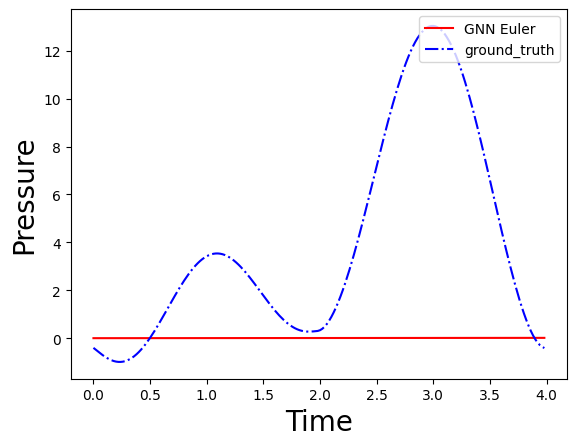

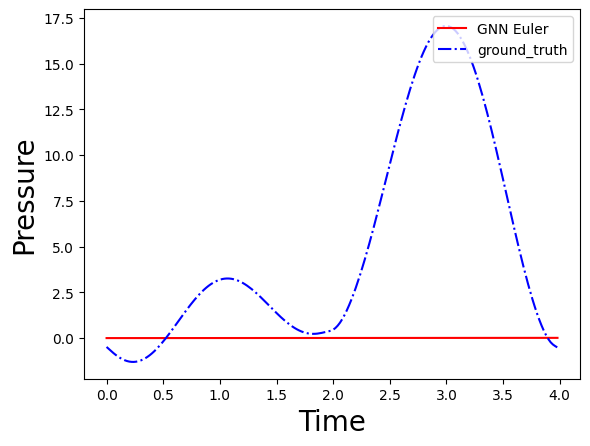

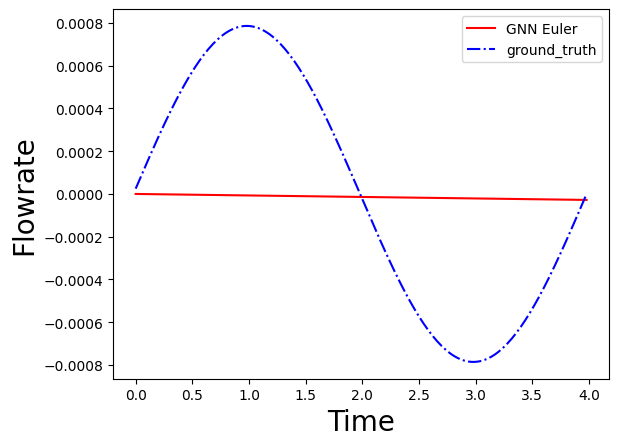

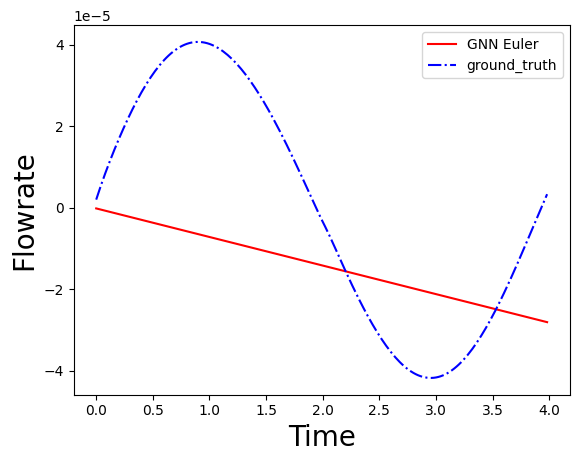

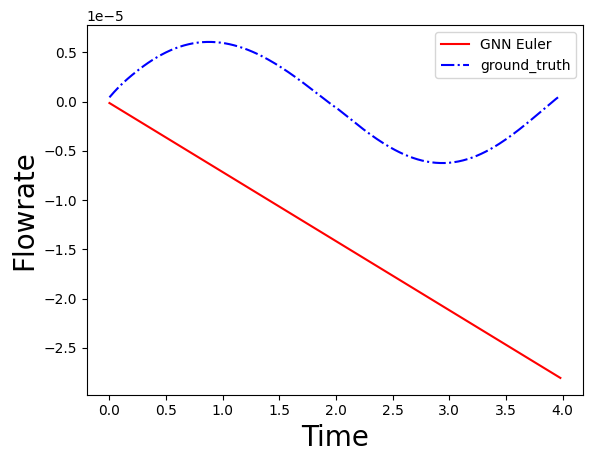

In [9]:
forward_sequence_validate = False
# Load to evaluate
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_WT',
    sub_dir='processed',
    # sub_dir='normed_and_batched',
    data_names='all',
    time_names=[str(i).zfill(3) for i in range(201)]
)

data = dataset[35]
# args.device = torch.device('cpu')
# prepare model
model = RecurrentFormulationNetwork(
    n_field=args.n_field,
    n_meshfield=args.n_meshfield,
    n_boundaryfield=args.n_boundaryfield,
    n_hidden=args.n_hidden,
    hidden_size=args.hidden_size,
    n_latent=args.n_latent,
    latent_size=args.latent_size,
    integration=None
)
model.load_state_dict(torch.load(
    'models/parc_test_epoch80.pth',
    map_location='cuda:0'
))
model=model.to(args.device)




F_true = torch.cat([
        data.pressure.unsqueeze(2),
        data.flowrate.unsqueeze(2)
    ], dim=2).float().to(args.device)
if not forward_sequence_validate:
    # forward only initial state
    F = F_true[:,0,:]
else:
    # forward all timestep
    F = F_true
F_true = F_true[:,1:,:]

## Connectivity/edge_index: Tensor(2, n_edge)
# edge_index = data.edge_index.to(args.device)
edge_index = torch.cat([
    data.edge_index, torch.flip(data.edge_index, dims=[0]
)], dim=1).to(args.device)

## Mesh features: Tuple(Tensor(n_node, n_node_attr), Tensor(n_edge, n_edge_attr))
node_attr = data.node_attr.float().to(args.device)
# edge_attr = data.edge_attr.float().to(args.device)
# edge_attr = torch.cat([data.edge_attr, data.edge_attr], dim=0).float().to(args.device)
edge_attr = None
meshfield = (node_attr, edge_attr)

## Boundary field
# boundaryfield = None
boundaryfield = torch.cat([data.flowrate[0,:].unsqueeze(0)]*data.flowrate.size(0), dim=0)
boundaryfield = boundaryfield.float().to(args.device)

## Time tensor
# time = data.time.float().to(args.device)
time = None

## Predict output sequence
with torch.no_grad():
    F_pred = model(
        F = F,
        edge_index=edge_index,
        meshfield=meshfield,
        boundaryfield=boundaryfield,
        time=time,
        forward_sequence=forward_sequence_validate,
        n_time=data.flowrate.size(1)
    )

node_list = [1, 10, 30]
## Draw pressure
import matplotlib.pyplot as plt
for i_node in node_list:
    i_field = 0
    y_pred = F_pred.cpu().numpy()[i_node,:,i_field]
    y_true = F_true.cpu().numpy()[i_node,:,i_field]
    # print(y_true, y_pred)
    x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
    # print(data.node_attr.numpy()[i_node, 6])
    # plt.ylim(-1,1)
    plt.plot(x, y_pred, c='red', label='GNN Euler')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
    # plt.ylim([-1,1])
    plt.legend(loc='upper right')
    plt.ylabel('Pressure', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()

## Draw flowrate
for i_node in node_list:
    i_field = 1
    y_pred = F_pred.cpu().numpy()[i_node,:,i_field]
    y_true = F_true.cpu().numpy()[i_node,:,i_field]
    x = [i * 4.0 /200 for i in range(y_pred.shape[0])]
    # print(data.node_attr.numpy()[i_node, 6])
    # plt.ylim(-1,1)
    plt.plot(x, y_pred, c='red', label='GNN Euler')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
    # plt.ylim([-1,1])
    plt.legend(loc='upper right')
    plt.ylabel('Flowrate', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()